# Problem Statement: Predict Airbnb Prices with low RMS

## TOC:


#### Exploratory Data Analysis
* [EDA-Introduction](#EDA-Introduction)
* [EDA-String Column Exploration & feature engineering](#EDA-String-Columns)
* [EDA-Deep Dive & Visuals](#EDA-Visual)

#### Preprocessing
* [Train Test Split](#TrainTestSplit)
* [DataFrameMapper](#DataFrameMapper)




#### Models
* [Naive Estimate](#NaiveEstimate)
* [Storing Function](#Storing-Function)
* [Linear Regression](#Model1)
* [Cross validated Lasso Regression](#Model2)
* [Huber Regression](#Model3)
* [Neural Network with Dropout](#Model4)







In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder, PolynomialFeatures 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer, MissingIndicator, IterativeImputer

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LassoCV, LinearRegression, ElasticNetCV, Lasso, LassoLarsCV, HuberRegressor
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline
import mummify

from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.feature_selection import SelectPercentile

from sklearn.pipeline import make_pipeline

In [72]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model

In [3]:
train_data=pd.read_csv("data/train.csv")
test_data=pd.read_csv("data/test.csv")

### EDA-Introduction

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
train_data.head()

id property_type        room_type  \
0  46730     Apartment      Shared room   
1  48393     Apartment  Entire home/apt   
2  41416     Apartment     Private room   
3  34506     Apartment  Entire home/apt   
4  43725     Apartment  Entire home/apt   

                                           amenities  accommodates  bathrooms  \
0  {TV,"Wireless Internet","Air conditioning",Kit...             2        1.0   
1  {TV,Internet,"Wireless Internet","Air conditio...             2        3.0   
2  {TV,"Cable TV","Wireless Internet","Air condit...             2        2.0   
3  {"Wireless Internet",Kitchen,"Family/kid frien...             4        1.0   
4  {TV,"Cable TV",Internet,"Wireless Internet","A...             4        1.0   

   bed_type cancellation_policy  cleaning_fee city  \
0  Real Bed            flexible         False  NYC   
1  Real Bed            moderate          True   LA   
2  Real Bed            flexible         False  NYC   
3  Real Bed            moderate          True  NYC   
4  Real Bed              strict          True   DC   

                                         description host_has_profile_pic  \
0  Квартира рядом с метро ( 3мин пешком) 4 станци...                    t   
1  Spacious, bright penthouse loft Condo in Brent...                    t   
2  Washington Heights. Brand new renovated, dark ...                    t   
3  Brownstone apartment in Harlem. Very quiet blo...                    t   
4  Welcome to my flat in DC!   About the apartmen...                    t   

  host_identity_verified host_response_rate  host_since instant_bookable  \
0                      f                NaN  2016-12-14                t   
1                      f                NaN  2016-02-27                f   
2                      t                70%  2012-03-05                f   
3                      f               100%  2017-07-31                f   
4                      f                50%  2011-05-22                f   

    latitude   longitude                                        name  \
0  40.577507  -73.985210  Не дорогая комната в Нью-Йорке, в Бруклине   
1  34.047200 -118.465782           Penthouse Loft Condo in Brentwood   
2  40.853085  -73.928880                         French Night in NYC   
3  40.807185  -73.949837                 Harlem brownstone apartment   
4  38.900307  -77.016468         "The Family" Flat Downtown DC- 1023   

        neighbourhood  number_of_reviews  review_scores_rating  zipcode  \
0        Coney Island                  1                 100.0  11224.0   
1           Brentwood                  2                 100.0    90049   
2  Washington Heights                  0                   NaN    10040   
3              Harlem                  2                 100.0    10027   
4    Judiciary Square                102                  95.0    20001   

   bedrooms  beds  price  
0       1.0   1.0   50.0  
1       1.0   1.0  200.0  
2       3.0   1.0   45.0  
3       2.0   3.0  130.0  
4       1.0   1.0  215.0

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
id                        50000 non-null int64
property_type             50000 non-null object
room_type                 50000 non-null object
amenities                 50000 non-null object
accommodates              50000 non-null int64
bathrooms                 49875 non-null float64
bed_type                  50000 non-null object
cancellation_policy       50000 non-null object
cleaning_fee              50000 non-null bool
city                      50000 non-null object
description               50000 non-null object
host_has_profile_pic      49877 non-null object
host_identity_verified    49877 non-null object
host_response_rate        37637 non-null object
host_since                49877 non-null object
instant_bookable          50000 non-null object
latitude                  50000 non-null float64
longitude                 50000 non-null float64
name                      50

In [6]:
#### Checking for null values
train_data.isnull().sum()

id                            0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   125
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
host_has_profile_pic        123
host_identity_verified      123
host_response_rate        12363
host_since                  123
instant_bookable              0
latitude                      0
longitude                     0
name                          0
neighbourhood              4569
number_of_reviews             0
review_scores_rating      11271
zipcode                     624
bedrooms                     55
beds                         73
price                         0
dtype: int64

In [7]:
### Summary Statistics
train_data.describe().T

count          mean           std         min  \
id                    50000.0  35067.620360  20201.229334    0.000000   
accommodates          50000.0      3.151780      2.170373    1.000000   
bathrooms             49875.0      1.233464      0.584081    0.000000   
latitude              50000.0     38.453568      3.079660   33.338905   
longitude             50000.0    -92.388038     21.709764 -122.510940   
number_of_reviews     50000.0     21.080140     38.113959    0.000000   
review_scores_rating  38729.0     94.053035      7.932111   20.000000   
bedrooms              49945.0      1.264631      0.859241    0.000000   
beds                  49927.0      1.709536      1.266431    0.000000   
price                 50000.0    159.502500    167.605699    1.000000   

                               25%           50%           75%           max  
id                    17564.000000  35101.500000  52547.250000  69999.000000  
accommodates              2.000000      2.000000      4.000000     16.000000  
bathrooms                 1.000000      1.000000      1.000000      8.000000  
latitude                 34.127573     40.662752     40.746226     42.390248  
longitude              -118.342612    -76.996397    -73.954355    -70.985047  
number_of_reviews         1.000000      6.000000     24.000000    605.000000  
review_scores_rating     92.000000     96.000000    100.000000    100.000000  
bedrooms                  1.000000      1.000000      1.000000     10.000000  
beds                      1.000000      1.000000      2.000000     18.000000  
price                    74.000000    110.000000    184.000000   1999.000000

In [8]:
# Checking length of bad data for columns deemed important 
len(train_data[ (train_data['host_has_profile_pic'].isnull()) 
              | (train_data['bedrooms'].isnull())
              | (train_data['host_since'].isnull())
              | (train_data['host_identity_verified'].isnull())
               | (train_data['bathrooms'].isnull())
              ])

299

In [9]:
train_data._get_numeric_data()

id  accommodates  bathrooms  cleaning_fee   latitude   longitude  \
0      46730             2        1.0         False  40.577507  -73.985210   
1      48393             2        3.0          True  34.047200 -118.465782   
2      41416             2        2.0         False  40.853085  -73.928880   
3      34506             4        1.0          True  40.807185  -73.949837   
4      43725             4        1.0          True  38.900307  -77.016468   
...      ...           ...        ...           ...        ...         ...   
49995  30085             2        1.0          True  40.677508  -73.981430   
49996  57551             2        1.0         False  40.765084  -73.909352   
49997  61640             2        1.0          True  40.720155  -73.990565   
49998   3569             2        1.0          True  37.805153 -122.435702   
49999  39305             2        1.0          True  41.898242  -87.690388   

       number_of_reviews  review_scores_rating  bedrooms  beds  price  
0                      1                 100.0       1.0   1.0   50.0  
1                      2                 100.0       1.0   1.0  200.0  
2                      0                   NaN       3.0   1.0   45.0  
3                      2                 100.0       2.0   3.0  130.0  
4                    102                  95.0       1.0   1.0  215.0  
...                  ...                   ...       ...   ...    ...  
49995                 16                  99.0       1.0   1.0  100.0  
49996                  0                   NaN       0.0   1.0   65.0  
49997                  1                 100.0       1.0   1.0  250.0  
49998                 38                  97.0       1.0   1.0  225.0  
49999                  1                 100.0       1.0   1.0   70.0  

[50000 rows x 11 columns]

### EDA-String-Columns

In [14]:
#Extracting amenities 

id_list=[]
tv=[]
internet=[]
essentials=[]
washer=[]
pets=[]
kitchen=[]
parking=[]
pool=[]
ac=[]
family=[]
hair_dryer=[]
private_entrance=[]
hot_tub=[]
total_amen=[]


def finder(x, to_find):
    if (x.lower().find(to_find.lower())) >-1:
            return 1
    else:
            return 0


def amenities_extractor(idx, ame):
    id_list.append(idx)
    tv.append(finder(ame,'tv'))
    internet.append(finder(ame,'internet'))
    essentials.append(finder(ame,'Essentials'))
    washer.append(finder(ame,'Washer'))
    pets.append(finder(ame,'Pets'))
    kitchen.append(finder(ame,'Kitchen'))
    parking.append(finder(ame,'parking'))
    pool.append(finder(ame,'pool'))
    ac.append(finder(ame,'Air con'))
    family.append(finder(ame,'Family/kid friendly'))
    hair_dryer.append(finder(ame,'Hair dryer'))
    private_entrance.append(finder(ame,'Private entr'))
    hot_tub.append(finder(ame,'Hot tub'))
    total_amen.append(len(ame.split(',')))            
    
    
    pass

strs='{TV,"Cable TV",Internet,"Wireless Internet","Air conditioning",Kitchen,"Free parking on premises",Gym,"Hot tub",Heating,"Smoke detector","Carbon monoxide detector",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Private entrance",Bathtub}'
amenities_extractor(1,strs)


In [15]:
train_data.apply(lambda x: amenities_extractor(x.id, x.amenities), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
49995    None
49996    None
49997    None
49998    None
49999    None
Length: 50000, dtype: object

In [16]:
ame=pd.DataFrame( 
list(zip(
id_list
,tv
,internet
,essentials
,washer
,pets
,kitchen
,parking
,pool
,ac
,family
,hair_dryer
,private_entrance
,hot_tub
,total_amen

)), columns=[
"id_list"
,"tv"
,"internet"
,"essentials"
,"washer"
,"pets"
,"kitchen"
,"parking"
,"pool"
,"ac"
,"family"
,"hair_dryer"
,"private_entrance"
,"hot_tub"
,"total_amen"
]
)

In [17]:
train_data=train_data.merge(ame, how='left',left_on='id', right_on="id_list")

In [18]:
#Adding length of description & name to dataframe

def description_length(x):
    return (len(x))
    

test_data['description_length']=test_data['description'].apply(description_length)
test_data['name_length']=test_data['name'].apply(description_length)

train_data['description_length']=train_data['description'].apply(description_length)
train_data['name_length']=train_data['name'].apply(description_length)

In [19]:
#Converting Response rate to float
def percentage_fixer(x):
    if type(x)==float:
        return np.nan
    return float(x.split('%')[0])    
test_data['host_response_rate']=test_data['host_response_rate'].apply(percentage_fixer)
train_data['host_response_rate']=train_data['host_response_rate'].apply(percentage_fixer)

In [20]:
test_data['host_since']=pd.to_datetime(test_data['host_since'])
train_data['host_since']=pd.to_datetime(train_data['host_since'])

In [21]:
# Number of days the host has been on Airbnb
test_data['age']=(pd.Timestamp.today()-test_data['host_since']).dt.days
train_data['age']=(pd.Timestamp.today()-train_data['host_since']).dt.days

In [22]:
train_data['log_price']=np.log(train_data['price'])


In [19]:
### 75% by city
city_quantiles=train_data.groupby('city', as_index=False)['price'].quantile(q=0.75)

print(city_quantiles)

def is_high(x):
    #quant=0
    #quant=city_quantiles[city_quantiles.city==x]['price']
    if x >= 185.0:
        return 1
    return 0

#train_data.apply(lambda x: is_high(x.city, x.price), axis=1)    
train_data['is_high']=train_data.price.apply(is_high)   
#train_data['is_high']

      city  price
0   Boston  200.0
1  Chicago  150.0
2       DC  225.0
3       LA  170.0
4      NYC  175.0
5       SF  250.0


In [20]:

train_data.describe().T

count          mean           std         min  \
id                    50001.0  35066.919042  20201.636015    0.000000   
accommodates          50001.0      3.151857      2.170419    1.000000   
bathrooms             49876.0      1.233459      0.584076    0.000000   
host_response_rate    37638.0     94.356209     16.350826    0.000000   
latitude              50001.0     38.453615      3.079647   33.338905   
longitude             50001.0    -92.387670     21.709702 -122.510940   
number_of_reviews     50001.0     21.079838     38.113638    0.000000   
review_scores_rating  38730.0     94.053008      7.932010   20.000000   
bedrooms              49946.0      1.264666      0.859267    0.000000   
beds                  49928.0      1.709562      1.266431    0.000000   
price                 50001.0    159.502690    167.604028    1.000000   
id_list               50001.0  35066.919042  20201.636015    0.000000   
tv                    50001.0      0.720586      0.448716    0.000000   
internet              50001.0      0.966141      0.180869    0.000000   
essentials            50001.0      0.862683      0.344185    0.000000   
washer                50001.0      0.589688      0.491895    0.000000   
pets                  50001.0      0.235635      0.424399    0.000000   
kitchen               50001.0      0.910462      0.285522    0.000000   
parking               50001.0      0.320394      0.466633    0.000000   
pool                  50001.0      0.084018      0.277418    0.000000   
ac                    50001.0      0.742005      0.437536    0.000000   
family                50001.0      0.496790      0.499995    0.000000   
hair_dryer            50001.0      0.585128      0.492705    0.000000   
private_entrance      50001.0      0.097518      0.296665    0.000000   
hot_tub               50001.0      0.084918      0.278763    0.000000   
total_amen            50001.0     17.579228      6.960205    1.000000   
description_length    50001.0    762.290954    317.284962    1.000000   
name_length           50001.0     34.845963      9.421284    1.000000   
age                   49878.0   1975.282389    662.452469  802.000000   
log_price             50001.0      4.778106      0.715765    0.000000   
is_high               50001.0      0.244635      0.429875    0.000000   

                               25%           50%           75%           max  
id                    17561.000000  35101.000000  52547.000000  69999.000000  
accommodates              2.000000      2.000000      4.000000     16.000000  
bathrooms                 1.000000      1.000000      1.000000      8.000000  
host_response_rate      100.000000    100.000000    100.000000    100.000000  
latitude                 34.127585     40.662759     40.746232     42.390248  
longitude              -118.342605    -76.996380    -73.954355    -70.985047  
number_of_reviews         1.000000      6.000000     24.000000    605.000000  
review_scores_rating     92.000000     96.000000    100.000000    100.000000  
bedrooms                  1.000000      1.000000      1.000000     10.000000  
beds                      1.000000      1.000000      2.000000     18.000000  
price                    74.000000    110.000000    184.000000   1999.000000  
id_list               17561.000000  35101.000000  52547.000000  69999.000000  
tv                        0.000000      1.000000      1.000000      1.000000  
internet                  1.000000      1.000000      1.000000      1.000000  
essentials                1.000000      1.000000      1.000000      1.000000  
washer                    0.000000      1.000000      1.000000      1.000000  
pets                      0.000000      0.000000      0.000000      1.000000  
kitchen                   1.000000      1.000000      1.000000      1.000000  
parking                   0.000000      0.000000      1.000000      1.000000  
pool                      0.000000      0.000000      0.000000      1.000000  
ac                        0.

### EDA-Visual

In [21]:
### Values by city
train_data.groupby('city')['city'].count()

city
Boston      2387
Chicago     2524
DC          3798
LA         15096
NYC        21816
SF          4380
Name: city, dtype: int64

In [22]:
neigh=train_data.groupby(by=(['city','neighbourhood']),as_index=False)['price'].mean()
neigh[neigh.city=='NYC'].sort_values(by='price').describe()
#neigh.city.unique()

price
count  192.000000
mean   127.462034
std     78.078611
min     35.000000
25%     77.447500
50%    102.246622
75%    154.900000
max    500.000000

In [23]:
#temp=train_data
len(train_data[train_data['price']>1200]),len(train_data[train_data['price']>175])



(266, 14050)

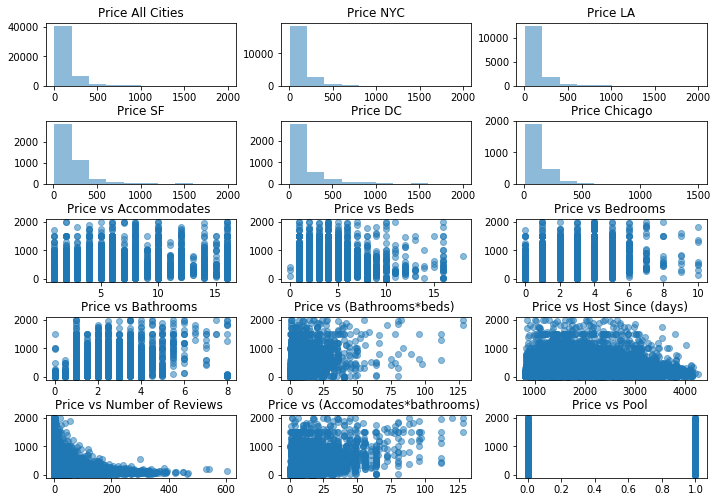

In [24]:
###Exploring price distributions
fig, ax = plt.subplots(5,3, figsize=(10,7))
fig.tight_layout(pad=1.4)
ax[0][0].set_title("Price All Cities")
ax[0][0].hist((train_data['price']), bins=10, alpha=0.5);

ax[0][1].set_title("Price NYC")
ax[0][1].hist(train_data[train_data.city=='NYC']['price'], bins=10, alpha=0.5);

ax[0][2].set_title("Price LA")
ax[0][2].hist(train_data[train_data.city=='LA']['price'], bins=10, alpha=0.5);


ax[1][0].set_title("Price SF")
ax[1][0].hist(train_data[train_data.city=='SF']['price'], bins=10, alpha=0.5);

ax[1][1].set_title("Price DC")
ax[1][1].hist(train_data[train_data.city=='DC']['price'], bins=10, alpha=0.5);

ax[1][2].set_title("Price Chicago")
ax[1][2].hist(train_data[train_data.city=='Chicago']['price'], bins=10, alpha=0.5);

ax[2][0].set_title("Price vs Accommodates ")
ax[2][0].scatter(y=train_data['price'], x=train_data.accommodates, alpha=0.5);


ax[2][1].set_title("Price vs Beds ")
ax[2][1].scatter(y=train_data['price'], x=train_data.beds, alpha=0.5);

ax[2][2].set_title("Price vs Bedrooms ")
ax[2][2].scatter(y=train_data['price'], x=train_data.bedrooms, alpha=0.5);

ax[3][0].set_title("Price vs Bathrooms ")
ax[3][0].scatter(y=train_data['price'], x=train_data.bathrooms, alpha=0.5);

ax[3][1].set_title("Price vs (Bathrooms*beds) ")
ax[3][1].scatter(y=train_data['price'], x=(train_data.bathrooms*train_data.beds), alpha=0.5);

ax[3][2].set_title("Price vs Host Since (days) ")
ax[3][2].scatter(y=train_data['price'], x=train_data.age, alpha=0.5);

ax[4][0].set_title("Price vs Number of Reviews ")
ax[4][0].scatter(y=train_data['price'], x=train_data.number_of_reviews, alpha=0.5);

ax[4][1].set_title("Price vs (Accomodates*bathrooms) ")
ax[4][1].scatter(y=train_data['price'], x=(train_data.bathrooms*train_data.accommodates), alpha=0.5);

ax[4][2].set_title("Price vs Pool ")
ax[4][2].scatter(y=train_data['price'], x=train_data.pool, alpha=0.5);





In [25]:
train_data.columns

Index(['id', 'property_type', 'room_type', 'amenities', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'description', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_rate', 'host_since', 'instant_bookable', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'zipcode', 'bedrooms', 'beds', 'price',
       'id_list', 'tv', 'internet', 'essentials', 'washer', 'pets', 'kitchen',
       'parking', 'pool', 'ac', 'family', 'hair_dryer', 'private_entrance',
       'hot_tub', 'total_amen', 'description_length', 'name_length', 'age',
       'log_price', 'is_high'],
      dtype='object')

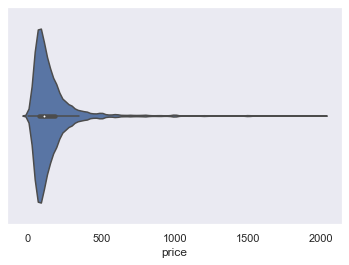

In [26]:
# Price
sns.set(style="dark")
sns.violinplot(x=train_data["price"]);

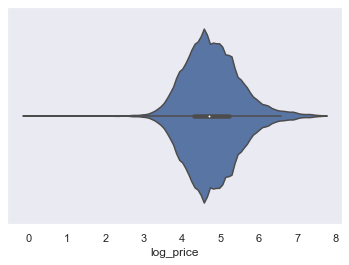

In [27]:
# Log Price
sns.set(style="dark")
sns.violinplot(x=train_data["log_price"]);

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


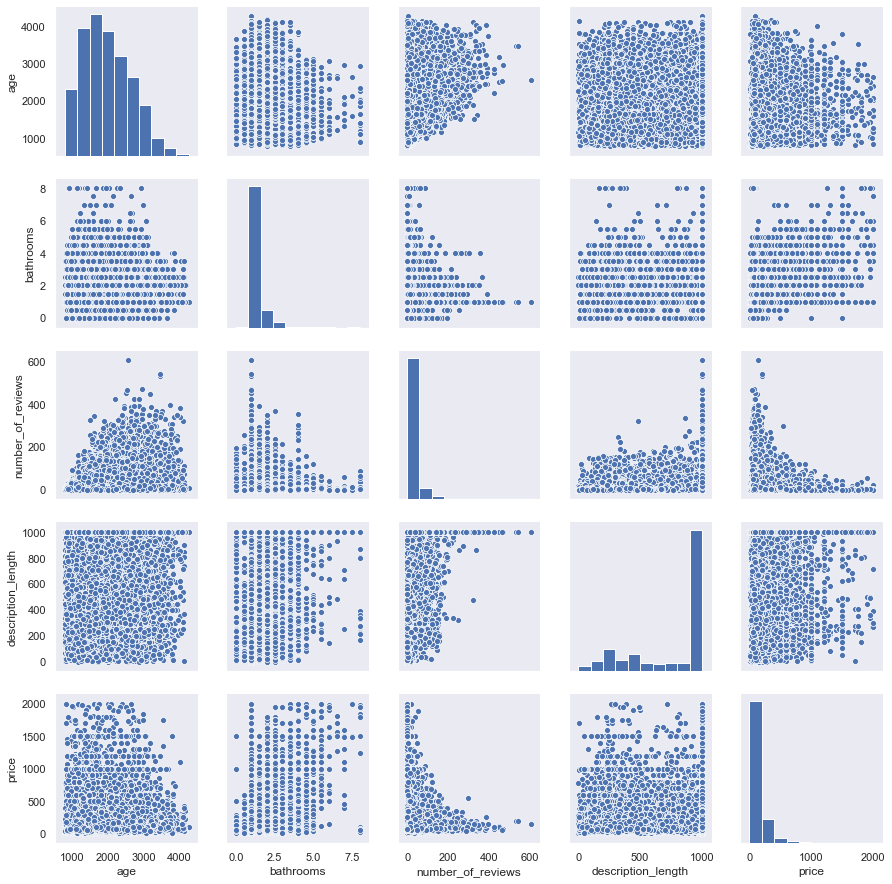

In [28]:
cols=['age', 'bathrooms', 'number_of_reviews','description_length', 'price']
sns.pairplot(train_data[cols])

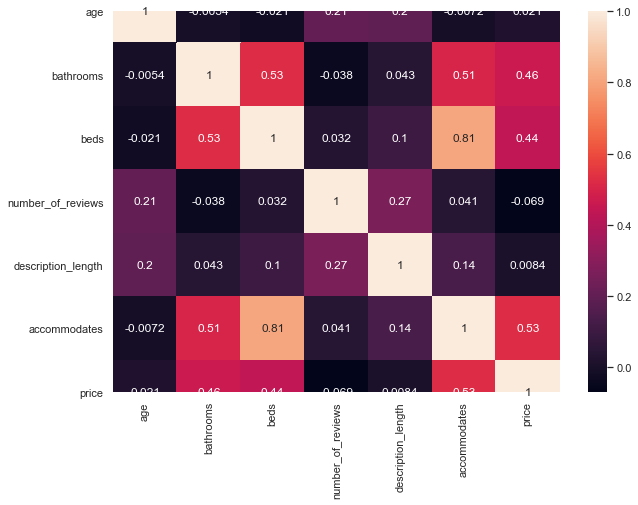

In [29]:
cols=['age', 'bathrooms','beds', 'number_of_reviews','description_length','accommodates', 'price']
plt.figure(figsize=(10,7))
sns.heatmap(train_data[cols].corr(), annot=True);

### NaiveEstimate

In [30]:
city_median=train_data.groupby('city', as_index=False)['price'].median()
city_median

city  price
0   Boston  136.0
1  Chicago   99.0
2       DC  125.0
3       LA  100.0
4      NYC  105.0
5       SF  164.5

In [31]:
def naive_predictor(x):

    return city_median[city_median['city']==x]['price'].values[0]

train_data['price_pred']=train_data['city'].apply(naive_predictor)

In [32]:
print("R^2 for naive estimator: ",r2_score(train_data['price'], train_data['price_pred']))

R^2 for naive estimator:  -0.06307309277701867


In [33]:
print("RMS for naive estimator: ",mean_squared_error(train_data['price'], train_data['price_pred'])**0.5)

RMS for naive estimator:  172.80713583031263


### Storing-Function

In [34]:
def store_results(test_data):
    test_data=test_data[['id','yhat']]
    test_data.rename(columns={'yhat' : 'price' }, inplace=True)
    test_data.to_csv("data/submit.csv", index=False)

### TrainTestSplit

In [25]:
target = 'price'
y = train_data[target]
X = train_data#.drop('price', axis=1)



In [26]:
X = X.drop('id', axis=1)
X.columns

Index(['property_type', 'room_type', 'amenities', 'accommodates', 'bathrooms',
       'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'description', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_rate', 'host_since', 'instant_bookable', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'zipcode', 'bedrooms', 'beds', 'price',
       'id_list', 'tv', 'internet', 'essentials', 'washer', 'pets', 'kitchen',
       'parking', 'pool', 'ac', 'family', 'hair_dryer', 'private_entrance',
       'hot_tub', 'total_amen', 'description_length', 'name_length', 'age',
       'log_price'],
      dtype='object')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [28]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.5)

In [29]:
X_train.shape, X_val.shape, X_test.shape

((37500, 44), (6250, 44), (6251, 44))

### DataFrameMapper

In [30]:
mapper=DataFrameMapper([

('cleaning_fee', LabelEncoder()),
( ['accommodates'], [ StandardScaler()]),
( ['number_of_reviews'], [ StandardScaler()]),
( ['bedrooms'], [SimpleImputer(strategy='median'), StandardScaler()]),
( ['bathrooms'], [SimpleImputer(strategy='median'), StandardScaler()]),
( ['review_scores_rating'], [SimpleImputer(strategy='median'), StandardScaler()]),
( ['longitude'], [ StandardScaler()]),
( ['latitude'], [ StandardScaler()]),
( ['beds'], [SimpleImputer(strategy='median'), StandardScaler()]),
####( 'zipcode', dtype('O'),
( 'neighbourhood', [CategoricalImputer(strategy='constant', fill_value='Unknown'), LabelBinarizer()]),
( 'instant_bookable', [LabelEncoder()]),
( 'property_type', [ LabelBinarizer()]),
( 'host_identity_verified',[CategoricalImputer(strategy='most_frequent'), LabelEncoder()]),
( 'host_has_profile_pic', [CategoricalImputer(strategy='most_frequent'), LabelEncoder()]),
( 'city', LabelBinarizer()),
( 'cancellation_policy', [ LabelBinarizer()]),
( 'bed_type', [LabelBinarizer()]),
( 'room_type', [LabelBinarizer()]),
###( 'host_response_rate', dtype('O')
('tv',LabelEncoder()),
('internet',LabelEncoder()),
('essentials',LabelEncoder()),
('washer',LabelEncoder()),
('pets',LabelEncoder()),
('kitchen',LabelEncoder()),
('parking',LabelEncoder()),
('pool',LabelEncoder()),
('ac',LabelEncoder()),
('family',LabelEncoder()),
('hair_dryer',LabelEncoder()),
('private_entrance',LabelEncoder()),
('hot_tub',LabelEncoder()),
( ['total_amen'], [ StandardScaler()]),
( ['description_length'], [ StandardScaler()]),
( ['name_length'], [ StandardScaler()]),
( ['age'], [SimpleImputer(strategy='median'), StandardScaler()]),
], df_out=True)


In [31]:
Z_train = mapper.fit_transform(X_train)



In [32]:
Z_val = mapper.transform(X_val)

In [33]:
select = SelectPercentile(percentile=30)

In [34]:
#%%timeit

select.fit(Z_train, y_train)
Z_train = select.transform(Z_train)
Z_val = select.transform(Z_val)
Z_train.shape, Z_val.shape

((37500, 198), (6250, 198))

In [35]:
poly=PolynomialFeatures(2, interaction_only=True )

In [36]:

poly.fit(Z_train)
Z_train=poly.transform(Z_train, )
Z_val=poly.transform(Z_val)
Z_train.shape, Z_val.shape

((37500, 19702), (6250, 19702))

In [37]:
select_two = SelectPercentile(percentile=10)

In [38]:

select_two.fit(Z_train, y_train)
Z_train = select_two.transform(Z_train)
Z_val = select_two.transform(Z_val)
Z_train.shape, Z_val.shape

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [    0   319  1936 ... 19512 19513 19531] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


((37500, 1971), (6250, 1971))

### Model1

##### Linear Regression

In [43]:
model_one=LinearRegression()

In [44]:
pipe_one = make_pipeline(mapper, select, poly, select_two,model_one)

In [45]:
pipe_one.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [    0   319  1936 ... 19512 19513 19531] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
         steps=[('dataframemapper',
                 DataFrameMapper(default=False, df_out=True,
                                 features=[('cleaning_fee', LabelEncoder()),
                                           (['accommodates'],
                                            [StandardScaler(copy=True,
                                                            with_mean=True,
                                                            with_std=True)]),
                                           (['number_of_reviews'],
                                            [StandardScaler(copy=True,
                                                            with_mean=True,
                                                            with_std=True)]),
                                           (['bedrooms'],
                                            [SimpleImputer(add_indicator=False,
                                                           copy=True,
                 

In [46]:
yhat_val=pipe_one.predict(X_val)
yhat_train=pipe_one.predict(X_train)

In [47]:
rms=mean_squared_error(y_val, yhat_val)**0.5
print("RMS for Linear Regression (Val): ",rms)
rms=mean_squared_error(y_train, yhat_train)**0.5
print("RMS for Linear Regression  (train): ",rms)

RMS for Linear Regression (Val):  213442879073.7462
RMS for Linear Regression  (train):  107.99998814855675


In [48]:
print("R^2 Score (Val)",r2_score(y_val, yhat_val))
print("R^2 Score (train)",r2_score(y_train, yhat_train))

R^2 Score (Val) -1.5559056347739937e+18
R^2 Score (train) 0.5808223718017924


### Model2

##### Cross validated Lasso Regression

In [49]:
model_two = LassoCV(max_iter=10000,n_jobs=-1, alphas=[0.03, 0.05,0.7])

In [50]:
pipe_two = make_pipeline(mapper, select, poly, select_two,model_two)

In [51]:
pipe_two.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [    0   319  1936 ... 19512 19513 19531] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Pipeline(memory=None,
         steps=[('dataframemapper',
                 DataFrameMapper(default=False, df_out=True,
                                 features=[('cleaning_fee', LabelEncoder()),
                                           (['accommodates'],
                                            [StandardScaler(copy=True,
                                                            with_mean=True,
                                                            with_std=True)]),
                                           (['number_of_reviews'],
                                            [StandardScaler(copy=True,
                                                            with_mean=True,
                                                            with_std=True)]),
                                           (['bedrooms'],
                                            [SimpleImputer(add_indicator=False,
                                                           copy=True,
                 

In [52]:
yhat_val=pipe_two.predict(X_val)
yhat_train=pipe_two.predict(X_train)

In [53]:
rms=mean_squared_error(y_val, yhat_val)**0.5
print("RMS for LassoCV Regression (Val): ",rms)
rms=mean_squared_error(y_train, yhat_train)**0.5
print("RMS for LassoCV Regression  (train): ",rms)

RMS for LassoCV Regression (Val):  122.98317954878868
RMS for LassoCV Regression  (train):  113.3415530440342


In [54]:
print("R^2 Score (Val)",r2_score(y_val, yhat_val))
print("R^2 Score (train)",r2_score(y_train, yhat_train))

R^2 Score (Val) 0.48345121221638865
R^2 Score (train) 0.5383328230312326


In [ ]:
params = {
    'alpha': [0.01,0.025, 0.05, 0.075,0.1],
    'fit_intercept': [True, False]
}

grid_trial = Lasso()

grid = GridSearchCV(grid_trial, params, cv=3, n_jobs=-1, verbose=1)

### Model3

In [55]:
model_three=HuberRegressor()

In [56]:
pipe_three = make_pipeline(mapper, select, poly, select_two,model_three)

In [57]:
pipe_three.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [    0   319  1936 ... 19512 19513 19531] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
         steps=[('dataframemapper',
                 DataFrameMapper(default=False, df_out=True,
                                 features=[('cleaning_fee', LabelEncoder()),
                                           (['accommodates'],
                                            [StandardScaler(copy=True,
                                                            with_mean=True,
                                                            with_std=True)]),
                                           (['number_of_reviews'],
                                            [StandardScaler(copy=True,
                                                            with_mean=True,
                                                            with_std=True)]),
                                           (['bedrooms'],
                                            [SimpleImputer(add_indicator=False,
                                                           copy=True,
                 

In [58]:
yhat_val=pipe_three.predict(X_val)
yhat_train=pipe_three.predict(X_train)

In [59]:
rms=mean_squared_error(y_val, yhat_val)**0.5
print("RMS for LassoCV Regression (Val): ",rms)
rms=mean_squared_error(y_train, yhat_train)**0.5
print("RMS for LassoCV Regression  (train): ",rms)

RMS for LassoCV Regression (Val):  128.25995352016344
RMS for LassoCV Regression  (train):  120.15640840123663


In [60]:
print("R^2 Score (Val)",r2_score(y_val, yhat_val))
print("R^2 Score (train)",r2_score(y_train, yhat_train))

R^2 Score (Val) 0.43817369491770297
R^2 Score (train) 0.4811467313528782


### Model4

In [41]:
Z_train.shape

(37500, 1971)

In [60]:
m = Sequential()
m.add(Dense(units=1000, activation='relu', input_shape=(Z_train.shape[1],)))
m.add(Dropout(0.2))
m.add(Dense(units=500, activation='relu'))
m.add(Dropout(0.2))
m.add(Dense(units=250, activation='relu'))
m.add(Dropout(0.25))
m.add(Dense(units=100, activation='relu'))
m.add(Dropout(0.2))
m.add(Dense(units=1, activation='linear'))

m.compile(loss='mse', optimizer='adam', metrics=['mae']) 

early_stop = EarlyStopping(monitor='mae', min_delta=0, patience=5)

model_checkpoint = ModelCheckpoint('data/best_model.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)


In [61]:
m.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 1000)              1972000   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 500)               500500    
_________________________________________________________________
dropout_21 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 250)               125250    
_________________________________________________________________
dropout_22 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)              

In [62]:

hist = m.fit( Z_train,
                    y_train, 
                    batch_size=128,
                    validation_data=(Z_val, y_val),
                    epochs=70,
                    callbacks=[early_stop, model_checkpoint],
                    verbose=1)

Train on 37500 samples, validate on 6250 samples
Epoch 1/70
37248/37500 [============================>.] - ETA: 0s - loss: 17211.3825 - mae: 68.8855
Epoch 00001: loss improved from inf to 17171.28024, saving model to data/best_model.h5
37500/37500 [==============================] - 10s 267us/sample - loss: 17171.2802 - mae: 68.8093 - val_loss: 15050.5899 - val_mae: 63.5287
Epoch 2/70
37248/37500 [============================>.] - ETA: 0s - loss: 14113.7877 - mae: 62.2002
Epoch 00002: loss improved from 17171.28024 to 14096.77717, saving model to data/best_model.h5
37500/37500 [==============================] - 10s 260us/sample - loss: 14096.7772 - mae: 62.1596 - val_loss: 14520.5392 - val_mae: 62.6161
Epoch 3/70
37376/37500 [============================>.] - ETA: 0s - loss: 13545.1863 - mae: 61.8027
Epoch 00003: loss improved from 14096.77717 to 13542.38852, saving model to data/best_model.h5
37500/37500 [==============================] - 10s 255us/sample - loss: 13542.3885 - mae: 61.7

Epoch 26/70
37376/37500 [============================>.] - ETA: 0s - loss: 6749.0158 - mae: 47.3576
Epoch 00026: loss did not improve from 6528.75235
37500/37500 [==============================] - 8s 216us/sample - loss: 6773.9883 - mae: 47.4003 - val_loss: 15160.1916 - val_mae: 58.8243
Epoch 27/70
37248/37500 [============================>.] - ETA: 0s - loss: 6317.6480 - mae: 46.2382
Epoch 00027: loss improved from 6528.75235 to 6349.08095, saving model to data/best_model.h5
37500/37500 [==============================] - 10s 254us/sample - loss: 6349.0810 - mae: 46.2747 - val_loss: 15790.9165 - val_mae: 61.0747
Epoch 28/70
37248/37500 [============================>.] - ETA: 0s - loss: 6334.8101 - mae: 46.2298
Epoch 00028: loss did not improve from 6349.08095
37500/37500 [==============================] - 9s 234us/sample - loss: 6372.2910 - mae: 46.3093 - val_loss: 15223.0480 - val_mae: 59.9555
Epoch 29/70
37248/37500 [============================>.] - ETA: 0s - loss: 6347.6484 - mae: 

Epoch 53/70
37376/37500 [============================>.] - ETA: 0s - loss: 4145.0873 - mae: 38.6970
Epoch 00053: loss did not improve from 4140.30754
37500/37500 [==============================] - 8s 202us/sample - loss: 4147.9171 - mae: 38.7162 - val_loss: 15450.1244 - val_mae: 59.1476
Epoch 54/70
37376/37500 [============================>.] - ETA: 0s - loss: 4321.3318 - mae: 39.0778- ETA: 1s - loss: 4390.7763 -
Epoch 00054: loss did not improve from 4140.30754
37500/37500 [==============================] - 9s 228us/sample - loss: 4318.0381 - mae: 39.0761 - val_loss: 15031.8392 - val_mae: 58.8044
Epoch 55/70
37248/37500 [============================>.] - ETA: 0s - loss: 4090.4168 - mae: 38.2939
Epoch 00055: loss improved from 4140.30754 to 4079.36104, saving model to data/best_model.h5
37500/37500 [==============================] - 8s 218us/sample - loss: 4079.3610 - mae: 38.2598 - val_loss: 15295.3492 - val_mae: 59.0573
Epoch 56/70
37376/37500 [============================>.] - ETA: 

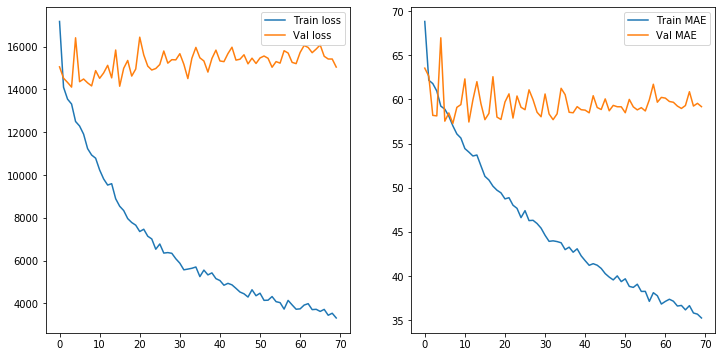

In [69]:
fig, ax= plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax[0].plot(hist.history['loss'], label='Train loss')
ax[0].plot(hist.history['val_loss'], label='Val loss')
ax[0].legend();

ax[1].plot(hist.history['mae'], label='Train MAE')
ax[1].plot(hist.history['val_mae'], label='Val MAE')
ax[1].legend();

In [73]:
m = load_model('data/best_model.h5')

In [74]:
yhat_val=m.predict(Z_val)
yhat_train=m.predict(Z_train)

In [77]:
rms=mean_squared_error(y_val, yhat_val)**0.5
print("RMS for ANN Regression (Val): ",rms)
rms=mean_squared_error(y_train, yhat_train)**0.5
print("RMS for ANN Regression  (train): ",rms)

RMS for ANN Regression (Val):  122.63859086442808
RMS for ANN Regression  (train):  45.69573139908759


In [76]:
print("R^2 Score (Val)",r2_score(y_val, yhat_val))
print("R^2 Score (train)",r2_score(y_train, yhat_train))

R^2 Score (Val) 0.486341810777947
R^2 Score (train) 0.9249584240183534


### Store Best results

In [ ]:
test_data['yhat']=pipe_two.predict(test_data)

In [ ]:
store_results(test_data)

In [ ]:
np.quantile(train_data['price'],0.75)

In [ ]:
#mummify.log(f'First full stab {rms}')